In [ ]:
# Install necessary libraries
!pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Load the dataset from Hugging Face
dataset = load_dataset('CyberNative/Code_Vulnerability_Security_DPO')

In [ ]:
# Inspect the dataset to find the correct column names
print(dataset.column_names)


{'train': ['lang', 'vulnerability', 'system', 'question', 'chosen', 'rejected']}


In [ ]:
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['lang', 'vulnerability', 'system', 'question', 'chosen', 'rejected'],
        num_rows: 4656
    })
})


# **Test Set**

In [ ]:
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

In [ ]:
# Load the dataset from Hugging Face
dataset = load_dataset('CyberNative/Code_Vulnerability_Security_DPO')

In [ ]:
# Convert the dataset to a pandas DataFrame
train_df = pd.DataFrame(dataset['train'])

# Split into training and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
# Display the first few rows of the dataset
print(train_df.head(5))

        lang                                      vulnerability system  \
3610  kotlin  Unchecked casts in Kotlin can lead to ClassCas...          
4036    ruby  The use of `eval` or `instance_eval` in Ruby c...          
2154  kotlin  Unchecked casts in Kotlin can lead to ClassCas...          
3298     php  The PHP `extract()` function can lead to arbit...          
517      c++  Buffer overflow vulnerability in C++ can occur...          

                                               question  \
3610  Write a kotlin code that defines a base class ...   
4036  Write a ruby code that creates a user class wi...   
2154  Write a kotlin code that creates an Animal cla...   
3298  Write a php code that takes user input, saniti...   
517   Write a c++ code that includes iostream and st...   

                                                 chosen  \
3610  ```kotlin\nopen class BaseClass\nclass Derived...   
4036  ```ruby\nclass User\n  attr_accessor :name\n\n...   
2154  ```kotlin\nimport

In [ ]:
# Display dataset information
print(train_df.info())

# Display the shape of the dataset
print("Dataset shape:", train_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 3724 entries, 3610 to 860
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lang           3724 non-null   object
 1   vulnerability  3724 non-null   object
 2   system         3724 non-null   object
 3   question       3724 non-null   object
 4   chosen         3724 non-null   object
 5   rejected       3724 non-null   object
dtypes: object(6)
memory usage: 203.7+ KB
None
Dataset shape: (3724, 6)


In [ ]:
# Check for missing values in the dataset
missing_values = train_df.isnull().sum()
print("Missing values:\n", missing_values)

# Visualize missing values using a heatmap (optional)
import seaborn as sns
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 6))
#sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
#plt.title("Missing Values Heatmap")
#plt.show()

Missing values:
 lang             0
vulnerability    0
system           0
question         0
chosen           0
rejected         0
dtype: int64


In [ ]:
# Get basic statistics of numerical columns (if any)
print("Statistical summary:\n", train_df.describe())

Statistical summary:
         lang                                      vulnerability system  \
count   3724                                               3724   3724   
unique    11                                               3539      1   
top       go  Cross-Site Scripting (XSS) vulnerabilities in ...          
freq     350                                                 12   3724   

                                                 question  \
count                                                3724   
unique                                               3361   
top     Write a kotlin code that prints the length of ...   
freq                                                   34   

                                                   chosen  \
count                                                3724   
unique                                               3584   
top     ```fortran\nprogram main\n    implicit none\n ...   
freq                                                   18

In [ ]:
# Count the number of unique languages in the dataset
unique_langs = train_df['lang'].nunique()
print("Number of unique languages:", unique_langs)

# Count the number of unique vulnerabilities
unique_vulnerabilities = train_df['vulnerability'].nunique()
print("Number of unique vulnerabilities:", unique_vulnerabilities)

Number of unique languages: 11
Number of unique vulnerabilities: 3539


Language distribution:
 lang
go            350
c#            347
java          347
javascript    346
kotlin        342
swift         339
python        337
fortran       336
php           332
ruby          324
c++           324
Name: count, dtype: int64


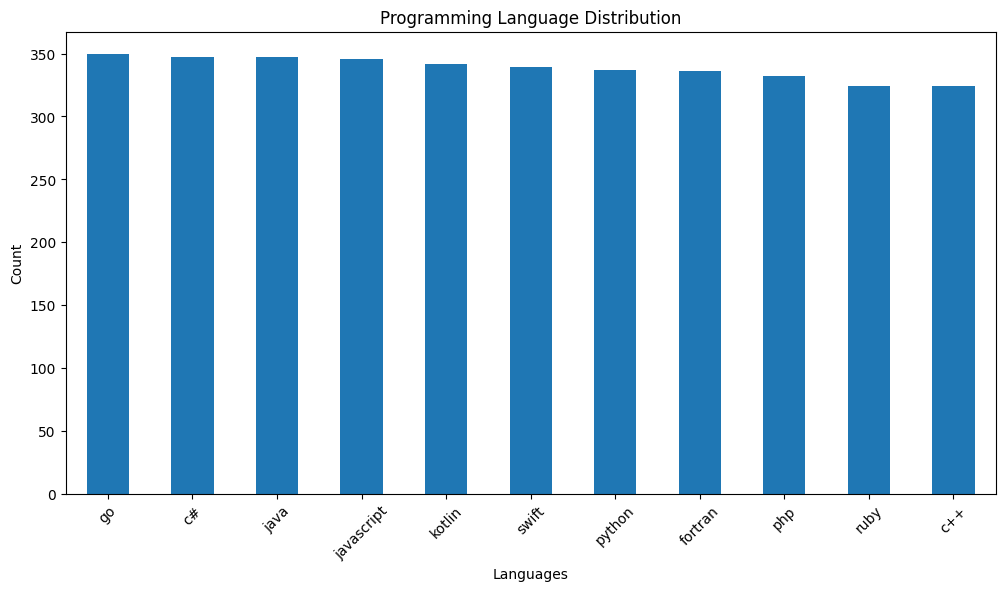

In [ ]:
# Count the number of samples per programming language
lang_counts = train_df['lang'].value_counts()
print("Language distribution:\n", lang_counts)

# Visualize the distribution of programming languages
plt.figure(figsize=(12, 6))
lang_counts.plot(kind='bar')
plt.title("Programming Language Distribution")
plt.xlabel("Languages")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Question Length Statistics:
 count    3724.000000
mean      284.586198
std       159.337162
min        54.000000
25%       156.750000
50%       246.000000
75%       386.000000
max      1007.000000
Name: question_length, dtype: float64
Chosen Code Length Statistics:
 count    3724.000000
mean      533.554243
std       435.305533
min        55.000000
25%       293.000000
50%       457.000000
75%       657.000000
max      8925.000000
Name: chosen_length, dtype: float64


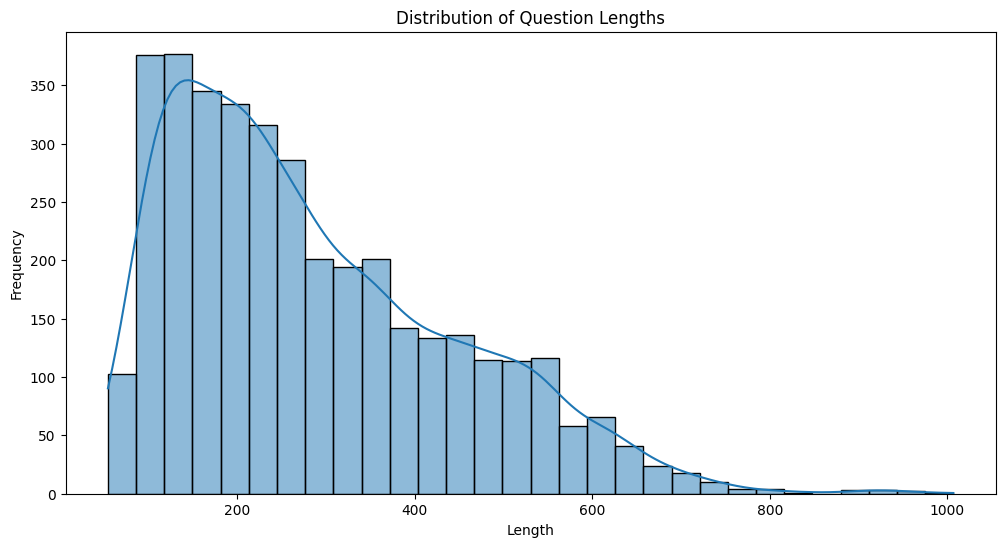

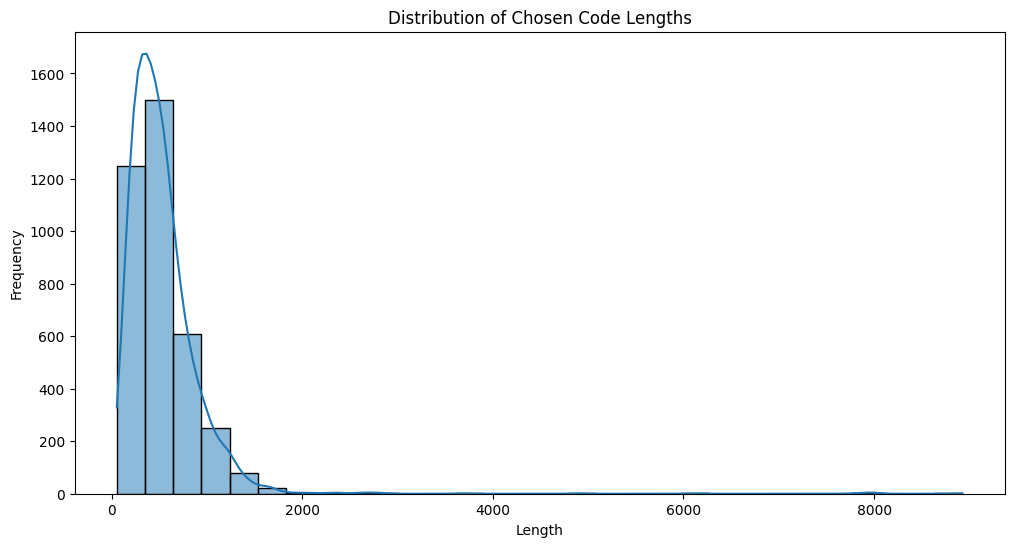

In [ ]:
# Add a column for the length of questions and chosen code
train_df['question_length'] = train_df['question'].apply(len)
train_df['chosen_length'] = train_df['chosen'].apply(len)

# Display the statistics of lengths
print("Question Length Statistics:\n", train_df['question_length'].describe())
print("Chosen Code Length Statistics:\n", train_df['chosen_length'].describe())

# Visualize the distribution of question lengths
plt.figure(figsize=(12, 6))
sns.histplot(train_df['question_length'], bins=30, kde=True)
plt.title("Distribution of Question Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

# Visualize the distribution of chosen code lengths
plt.figure(figsize=(12, 6))
sns.histplot(train_df['chosen_length'], bins=30, kde=True)
plt.title("Distribution of Chosen Code Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df is already defined, let's check its info
print(train_df.info())

# Convert categorical columns to numeric if needed (this is optional)
# For demonstration, we'll use one-hot encoding for non-numeric columns
# This step might change based on your specific needs
train_df_encoded = pd.get_dummies(train_df, drop_first=True)

# Now we can calculate the correlation matrix
correlation_matrix = train_df_encoded.corr()

# Print the correlation matrix
print("Correlation matrix:\n", correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 3724 entries, 3610 to 860
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   lang             3724 non-null   object
 1   vulnerability    3724 non-null   object
 2   system           3724 non-null   object
 3   question         3724 non-null   object
 4   chosen           3724 non-null   object
 5   rejected         3724 non-null   object
 6   question_length  3724 non-null   int64 
 7   chosen_length    3724 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 261.8+ KB
None


In [ ]:
# Convert back to Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
# Load the tokenizer for CodeBERT
tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')

# Preprocess function for tokenization
def preprocess_function(examples):
    # Concatenating the question and the chosen code snippet for context
    inputs = [f"Question: {question} Code: {code}" for question, code in zip(examples['question'], examples['chosen'])]
    # Tokenizing the inputs
    tokenized_inputs = tokenizer(inputs, truncation=True, padding="max_length", max_length=512)

    # Binary labels based on vulnerability description
    labels = [1 if "vulnerability" in vulnerability else 0 for vulnerability in examples['vulnerability']]

    # Return a dictionary with input_ids, attention_mask, and labels
    return {**tokenized_inputs, 'labels': labels}

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Apply preprocessing to train and validation datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3724 [00:00<?, ? examples/s]

Map:   0%|          | 0/932 [00:00<?, ? examples/s]

In [ ]:
# Load the model for code vulnerability detection (binary classification)
model = RobertaForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define a compute metrics function
def compute_metrics(p):
    predictions, labels = p
    preds = torch.tensor(np.argmax(predictions, axis=1))  # Convert predictions to tensor
    labels = torch.tensor(labels)  # Ensure labels are also in tensor format
    precision, recall, f1, _ = precision_recall_fscore_support(labels.numpy(), preds.numpy(), average='binary')
    acc = accuracy_score(labels.numpy(), preds.numpy())
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Add the compute_metrics function here
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.392600,0.576137,0.844421,0.721689,0.752000,0.693727
2,0.181300,0.534241,0.842275,0.729282,0.727941,0.730627
3,0.240700,0.604004,0.842275,0.721063,0.742188,0.701107


TrainOutput(global_step=1398, training_loss=0.3336058187382416, metrics={'train_runtime': 1288.7419, 'train_samples_per_second': 8.669, 'train_steps_per_second': 1.085, 'total_flos': 2939476710481920.0, 'train_loss': 0.3336058187382416, 'epoch': 3.0})

In [ ]:
# Evaluate the model and print metrics
metrics = trainer.evaluate()
print("Evaluation metrics:")
print(metrics)

Evaluation metrics:
{'eval_loss': 0.6040043830871582, 'eval_accuracy': 0.842274678111588, 'eval_f1': 0.7210626185958254, 'eval_precision': 0.7421875, 'eval_recall': 0.7011070110701108, 'eval_runtime': 29.4905, 'eval_samples_per_second': 31.603, 'eval_steps_per_second': 3.967, 'epoch': 3.0}


 ***15 epocs***

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Add the compute_metrics function here
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.317200,0.754646,0.830472,0.682731,0.748899,0.627306
2,0.083900,0.698729,0.846567,0.730697,0.746154,0.715867
3,0.270900,0.638470,0.799356,0.696921,0.621387,0.793358
4,0.213400,0.738827,0.837983,0.697395,0.763158,0.642066
5,0.220500,0.727922,0.842275,0.716763,0.750000,0.686347
6,0.360200,0.893948,0.807940,0.687609,0.652318,0.726937
7,0.160800,1.137773,0.815451,0.679104,0.686792,0.671587
8,0.080400,0.997145,0.827253,0.702403,0.703704,0.701107
9,0.093000,0.966482,0.833691,0.703633,0.730159,0.678967
10,0.047400,1.106789,0.837983,0.706796,0.745902,0.671587


TrainOutput(global_step=6990, training_loss=0.15456160505885827, metrics={'train_runtime': 6199.4562, 'train_samples_per_second': 9.01, 'train_steps_per_second': 1.128, 'total_flos': 1.46973835524096e+16, 'train_loss': 0.15456160505885827, 'epoch': 15.0})

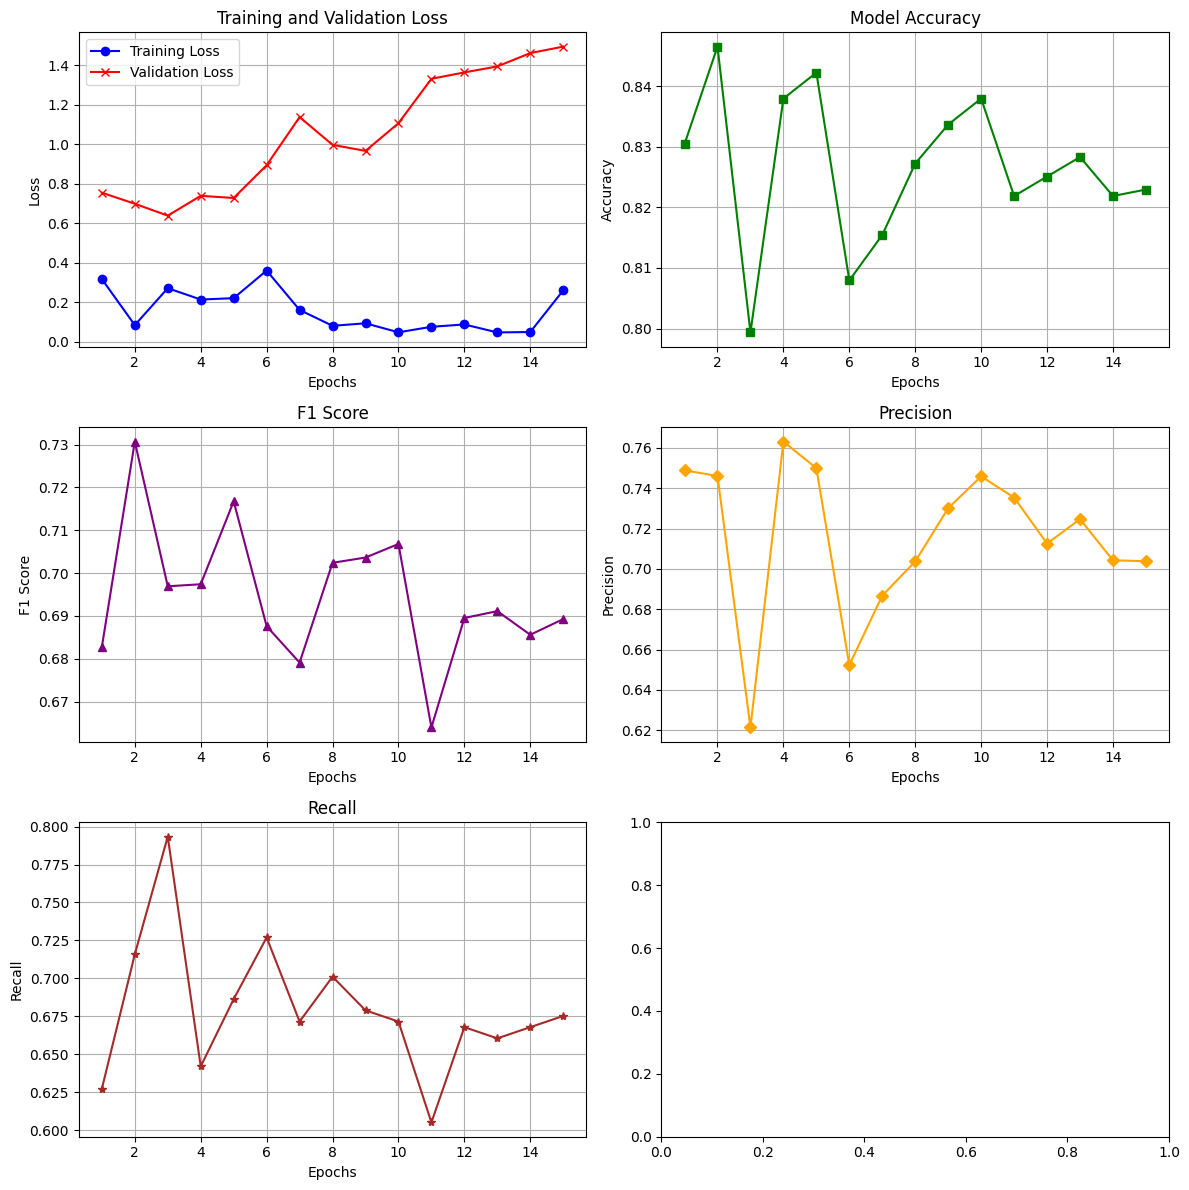

In [ ]:
import matplotlib.pyplot as plt

# Define the epoch data and metrics
epochs = list(range(1, 16))
training_loss = [
    0.317200, 0.083900, 0.270900, 0.213400, 0.220500,
    0.360200, 0.160800, 0.080400, 0.093000, 0.047400,
    0.075400, 0.087200, 0.046800, 0.048900, 0.260000
]
validation_loss = [
    0.754646, 0.698729, 0.638470, 0.738827, 0.727922,
    0.893948, 1.137773, 0.997145, 0.966482, 1.106789,
    1.331745, 1.364117, 1.394439, 1.461986, 1.494751
]
accuracy = [
    0.830472, 0.846567, 0.799356, 0.837983, 0.842275,
    0.807940, 0.815451, 0.827253, 0.833691, 0.837983,
    0.821888, 0.825107, 0.828326, 0.821888, 0.822961
]
f1_score = [
    0.682731, 0.730697, 0.696921, 0.697395, 0.716763,
    0.687609, 0.679104, 0.702403, 0.703633, 0.706796,
    0.663968, 0.689524, 0.691120, 0.685606, 0.689266
]
precision = [
    0.748899, 0.746154, 0.621387, 0.763158, 0.750000,
    0.652318, 0.686792, 0.703704, 0.730159, 0.745902,
    0.735426, 0.712598, 0.724696, 0.704280, 0.703846
]
recall = [
    0.627306, 0.715867, 0.793358, 0.642066, 0.686347,
    0.726937, 0.671587, 0.701107, 0.678967, 0.671587,
    0.605166, 0.667897, 0.660517, 0.667897, 0.675277
]

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Plot Training and Validation Loss
axs[0, 0].plot(epochs, training_loss, label='Training Loss', color='blue', marker='o')
axs[0, 0].plot(epochs, validation_loss, label='Validation Loss', color='red', marker='x')
axs[0, 0].set_title('Training and Validation Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Accuracy
axs[0, 1].plot(epochs, accuracy, label='Accuracy', color='green', marker='s')
axs[0, 1].set_title('Model Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].grid()

# Plot F1 Score
axs[1, 0].plot(epochs, f1_score, label='F1 Score', color='purple', marker='^')
axs[1, 0].set_title('F1 Score')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('F1 Score')
axs[1, 0].grid()

# Plot Precision
axs[1, 1].plot(epochs, precision, label='Precision', color='orange', marker='D')
axs[1, 1].set_title('Precision')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].grid()

# Plot Recall
axs[2, 0].plot(epochs, recall, label='Recall', color='brown', marker='*')
axs[2, 0].set_title('Recall')
axs[2, 0].set_xlabel('Epochs')
axs[2, 0].set_ylabel('Recall')
axs[2, 0].grid()

# Adjust layout
plt.tight_layout()
plt.show()


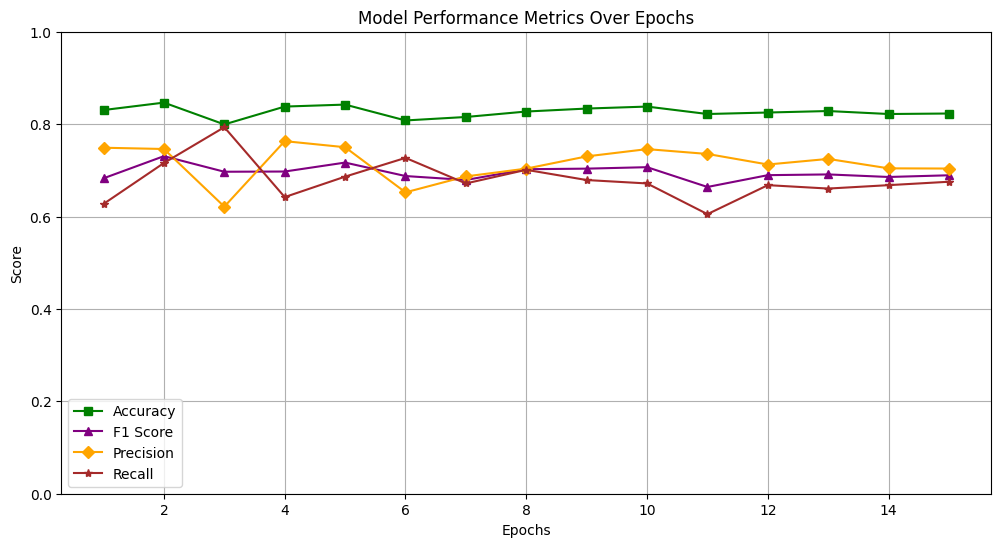

In [ ]:
# Create a plot for accuracy, F1 score, precision, and recall
plt.figure(figsize=(12, 6))

# Plotting all metrics
plt.plot(epochs, accuracy, label='Accuracy', color='green', marker='s')
plt.plot(epochs, f1_score, label='F1 Score', color='purple', marker='^')
plt.plot(epochs, precision, label='Precision', color='orange', marker='D')
plt.plot(epochs, recall, label='Recall', color='brown', marker='*')

# Setting title and labels
plt.title('Model Performance Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits to [0, 1]
plt.legend()
plt.grid()

# Show plot
plt.show()



---



---



In [ ]:
# Define a compute metrics function
def compute_metrics(p):
    predictions, labels = p
    preds = torch.tensor(np.argmax(predictions, axis=1))  # Convert predictions to tensor
    labels = torch.tensor(labels)  # Ensure labels are also in tensor format
    precision, recall, f1, _ = precision_recall_fscore_support(labels.numpy(), preds.numpy(), average='binary')
    acc = accuracy_score(labels.numpy(), preds.numpy())
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Custom Trainer Class to include training and validation accuracy after each epoch
class CustomTrainer(Trainer):
    def train(self, *args, **kwargs):
        # Call the original train method for setup
        super().train(*args, **kwargs)

        # Calculate training accuracy at the end of each epoch
        for epoch in range(self.args.num_train_epochs):
            # Evaluate training accuracy
            train_metrics = self.evaluate(self.train_dataset)
            print(f"Epoch {epoch + 1}/{self.args.num_train_epochs} - Training Accuracy: {train_metrics['eval_accuracy']:.4f}")

            # Evaluate validation accuracy
            val_metrics = self.evaluate(self.eval_dataset)
            print(f"Epoch {epoch + 1}/{self.args.num_train_epochs} - Validation Accuracy: {val_metrics['eval_accuracy']:.4f}")

        return

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch"
)

# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize the Custom Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Add the compute_metrics function here
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.096900,1.023395,0.822961,0.679612,0.717213,0.645756
2,0.052500,1.278687,0.829399,0.677485,0.752252,0.616236
3,0.000400,1.319346,0.830472,0.697318,0.725100,0.671587


Epoch 1/3 - Training Accuracy: 0.9930
Epoch 1/3 - Validation Accuracy: 0.8305
Epoch 2/3 - Training Accuracy: 0.9930
Epoch 2/3 - Validation Accuracy: 0.8305
Epoch 3/3 - Training Accuracy: 0.9930
Epoch 3/3 - Validation Accuracy: 0.8305


In [ ]:
'''
# Save the trained model
model.save_pretrained("./code_vulnerability_model")

# Download the saved model directory as a zip file
import shutil

shutil.make_archive("code_vulnerability_model", 'zip', "./code_vulnerability_model")
'''